# SNN Loss based on Cosine Distance

In this notebook, we'll see an example of how to use the SNN loss based on cosine distance. The cosine distance is a measure of similarity between two vectors. It is calculated as the cosine of the angle between the two vectors, and ranges from -1 to 1, with -1 indicating that the two vectors are completely dissimilar, 0 indicating that the two vectors are orthogonal, and 1 indicating that the two vectors are identical.

We'll start with 6 random vectors, and by optimizing the SNN loss, we'll group them into pointing at the same direction, equally distributed in the space.

First, let's import the `contrastive` library and the `torch` library. Notice that `torch` should be loaded before `contrastive` to avoid some errors.

In [1]:
import torch
import contrastive

We also import auxiliary libraries to help us with the visualization of the results:

In [2]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

We define the device to be used (GPU or CPU):

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We create a batch of 6 random vectors of size 2, and define the labels for the vectors - the first two vectors are positive examples, the next two are positive examples, and the last two are positive examples. The negative examples are the vectors that are not in the same group.

In [4]:
z = torch.randn(6, 2, requires_grad=True, device=device) # We require gradients to update the embeddings
labels = torch.tensor([0, 0, 1, 1, 2, 2], device=device)

We write a function that will plot the vectors and color them according to their labels:

In [5]:
def plot_vectors(z, labels):
    """ Plots the vectors, each vector is represented by an arrow, the color of the arrow represents the label of the vector"""
    plt.figure()
    for i in range(len(z)):
        plt.arrow(0, 0, z.detach().cpu().numpy()[i, 0], z.detach().cpu().numpy()[i, 1], head_width=0.1, head_length=0.1, color=plt.cm.tab10(labels[i].cpu().numpy() / 2))
    max_x = z.detach().abs().max().item() * 1.1
    max_y = z.detach().abs().max().item() * 1.1
    plt.xlim(-max_x, max_x)
    plt.ylim(-max_y, max_y)
    plt.show()

And use it to plot the vectors:

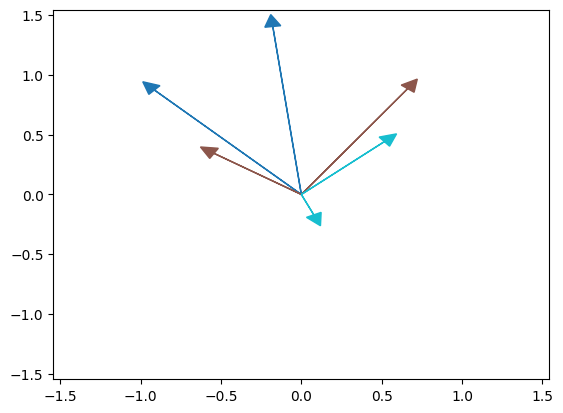

In [6]:
plot_vectors(z, labels)

Now, let's optimize the vectors to minimize the SNN loss function (notice we're using the cosine distance as the similarity measure, by setting the `use_cosine` parameter to `True`):

In [7]:
# define the optimizer
optimizer = torch.optim.Adam([z], lr=1e-1)

# log the loss
losses = []

# optimize the vectors to minimize the loss
pbar = tqdm(range(1_000))
for i in pbar:
    optimizer.zero_grad()
    result = contrastive.snnl(tensor=z, labels=labels, temperature=1, reduce="mean", use_cosine=True)
    result.backward()
    optimizer.step()
    losses.append(result.item())
    if i % 100 == 0:
        pbar.set_postfix({"loss": f"{result.item():.4f}"})

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's plot the loss behavior during the optimization process. We expect the loss to decrease over time but not to reach zero, as the SNN loss has a lower bound:

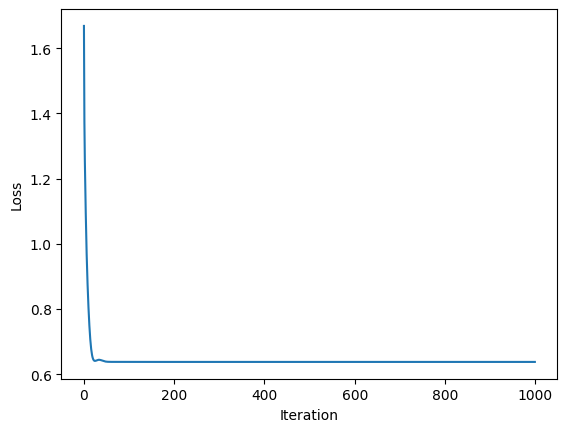

In [8]:
# plot the loss
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Now let's plot the vectors again, colored by the labels. We expect the vectors with the same label to point in the same direction, and we expect the groups to be equally distributed in the space:

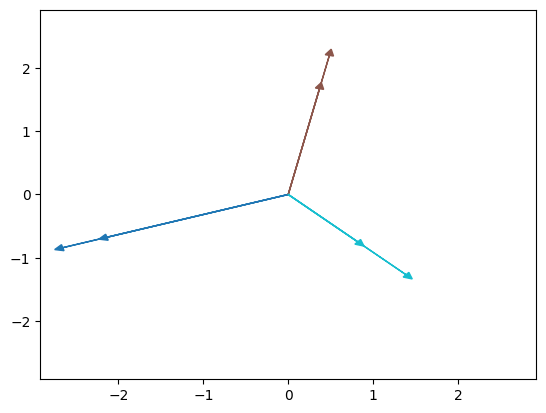

In [9]:
plot_vectors(z, labels)